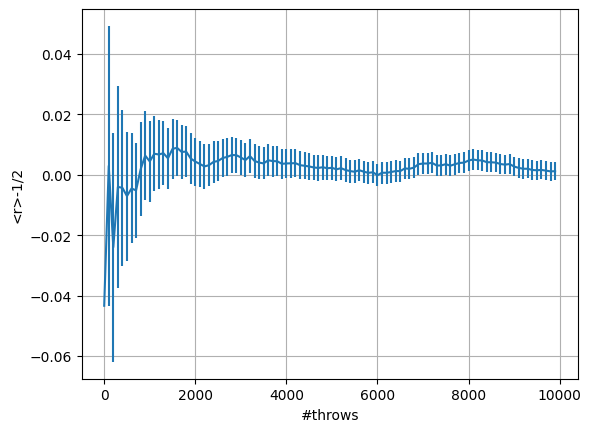

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy.stats as ss

avg_prog, error_prog = np.loadtxt("Ex1_1_1.csv", delimiter=',', usecols=(0, 1), unpack=True)

M = 10000
N = 100

L = M / N

x = np.arange(N)
x = x * L

plt.errorbar(x,avg_prog,yerr=error_prog)
plt.xlabel('#throws')
plt.ylabel('<r>-1/2')
plt.grid(True)
plt.show()

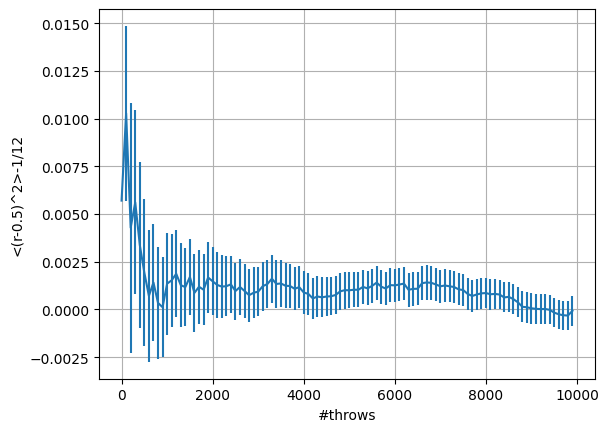

In [2]:
avg_prog, error_prog = np.loadtxt("Ex1_1_2.csv", delimiter=',', usecols=(0, 1), unpack=True)

plt.errorbar(x,avg_prog,yerr=error_prog)
plt.xlabel('#throws')
plt.ylabel('<(r-0.5)^2>-1/12')
plt.grid(True)
plt.show()

In [14]:
def param_chi(x, a):
    
    return a * ss.chi(x)

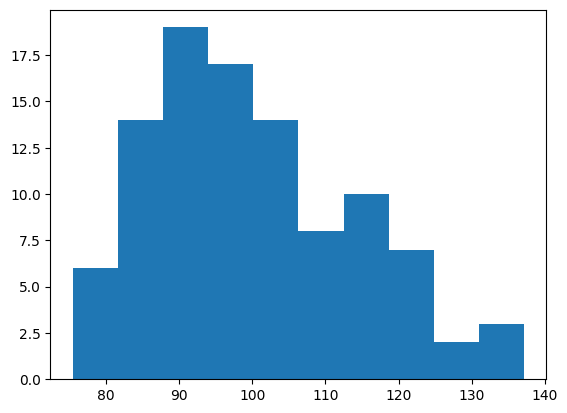

In [3]:
idx, chi = np.loadtxt("Ex1_1_3.csv", delimiter=',', usecols=(0, 1), unpack=True)

counts, bins = np.histogram(chi)
plt.hist(bins[:-1], bins, weights=counts)
plt.show()

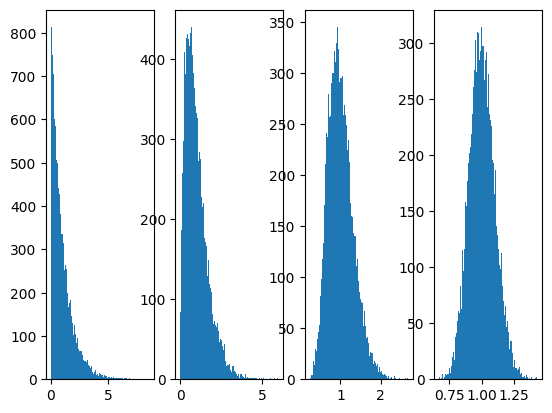

In [4]:
exp_data = np.loadtxt("Ex1_2_exp.csv", delimiter=',')

fig, axs = plt.subplots(1, 4)

for i in range(0, 4):

    counts, bins = np.histogram(exp_data[:,i],100)
    axs[i].hist(bins[:-1], bins, weights=counts)

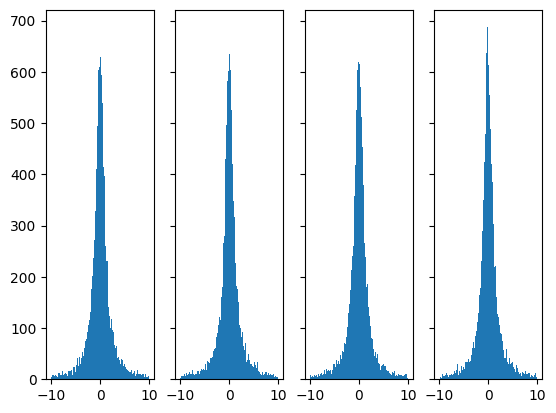

In [6]:
cl_data = np.loadtxt("Ex1_2_cl.csv", delimiter=',')

fig, axs = plt.subplots(1, 4, sharey='row')

for i in range(0, 4):

    counts, bins = np.histogram(cl_data[:,i], 100, [-10, 10])
    axs[i].hist(bins[:-1], bins, weights=counts)

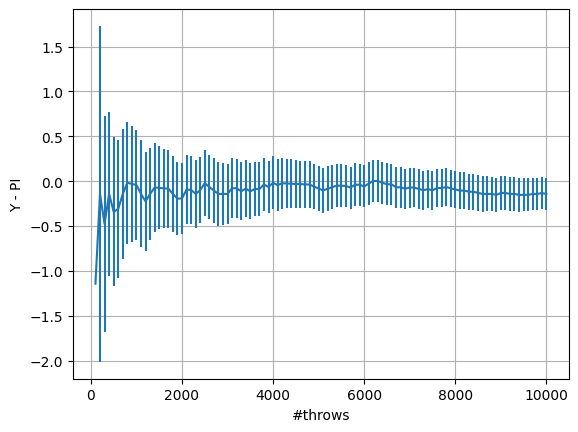

In [12]:
pi_data = np.loadtxt("Ex1_3.csv", delimiter=',')
x = np.arange(1, 101, 1) * 100

plt.errorbar(x,pi_data[:,0] - math.pi,yerr=pi_data[:,1])
plt.xlabel('#throws')
plt.ylabel('Y - PI')
plt.grid(True)
plt.show()